# Hierarchical Photo-z's on SDSS Data

Part 6 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook applies the results from Part 4/5 (run over mock SDSS/HSC data, respectively) to **real** SDSS data!

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot
from astropy.io import fits # reading fits files

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

We run this query within http://casjobs.sdss.org/ on the Data Release 13 scheme:

    SELECT top 200000 p.objId as OBJID,
    p.ra as RA, p.dec as DEC,
    p.type as PHOTPTYPE, dbo.fPhotoTypeN(p.type) as PHOT_SG,
  
    p.DERED_R, p.DERED_I, p.DERED_Z,
  
    p.CMODELFLUX_U, p.CMODELFLUXIVAR_U, p.CMODELFLUX_G,p.CMODELFLUXIVAR_G,
    p.CMODELFLUX_R, p.CMODELFLUXIVAR_R, p.CMODELFLUX_I,p.CMODELFLUXIVAR_I,
    p.CMODELFLUX_Z, p.CMODELFLUXIVAR_Z,

    p.PSFFLUX_U-p.EXTINCTION_U as PSFFLUX_U, p.PSFFLUXIVAR_U, 
    p.PSFFLUX_G-p.EXTINCTION_G as PSFFLUX_G, p.PSFFLUXIVAR_G, 
    p.PSFFLUX_R-p.EXTINCTION_R as PSFFLUX_R, p.PSFFLUXIVAR_R,
    p.PSFFLUX_I-p.EXTINCTION_I as PSFFLUX_I, p.PSFFLUXIVAR_I, 
    p.PSFFLUX_Z-p.EXTINCTION_Z as PSFFLUX_Z, p.PSFFLUXIVAR_Z, 
  
    p.FIBERFLUX_U-p.EXTINCTION_U as FIBERFLUX_U, p.FIBERFLUXIVAR_U,
    p.FIBERFLUX_G-p.EXTINCTION_G as FIBERFLUX_G, p.FIBERFLUXIVAR_G,
    p.FIBERFLUX_R-p.EXTINCTION_R as FIBERFLUX_R, p.FIBERFLUXIVAR_R, 
    p.FIBERFLUX_I-p.EXTINCTION_I as FIBERFLUX_I, p.FIBERFLUXIVAR_I,
    p.FIBERFLUX_Z-p.EXTINCTION_Z as FIBERFLUX_Z, p.FIBERFLUXIVAR_Z,

    p.FRACDEV_R,
    p.EXPRAD_R, p.EXPRADERR_R,
    p.PETROR50_R, p.PETROR90_R,
    p.DEVRAD_R, p.DEVRADERR_R,"
  
    ISNULL(s.z,-1) as SPEC_Z, ISNULL(s.zErr,-1) as SPEC_Z_ERR, 
    ISNULL(pz.z,-1) as PHOTOZ, ISNULL(pz.zerr,-1) as PHOTOZ_ERR,

    s.specObjID as SPECOBJID, ISNULL(s.class,-1) as SPEC_CLASS, ISNULL(s.subClass,-1) as SPEC_SUBCLASS 
    
    FROM SpecPhotoAll s 
    INTO mydb.SDSS_DR13_FRANKZ
      JOIN PhotoPrimary p ON  s.ObjID = p.ObjID and s.zWarning is not NULL and s.specObjID is not NULL and p.type=3 and s.ObjID is not NULL and s.zWarning=0
    JOIN PHOTOZ pz ON s.ObjID = pz.ObjID

In [2]:
hdul = fits.open('data/SDSS_DR13_FRANKZ_hoyleb_0.fits')
data = hdul[1].data
data = data[unique(data['RA'], return_index=True)[1]]

In this case, where our entire sample is our training sample, we will conduct leave-one-out cross-validation over the entire dataset.

In [3]:
# applying quality cuts to ensure data is reliable
ind_reliable = ((data['SPEC_Z'] > 1e-3) & (data['SPEC_Z_ERR'] < 1e-4) 
             & ([i.replace(' ','') == 'GALAXY' for i in data['SPEC_CLASS']]))
print('Initial {:} -> clean training data size {:}'.format(len(ind_reliable), sum(ind_reliable)))
data = data[ind_reliable]
Nobs = len(data)

Initial 173943 -> clean training data size 99781


In [14]:
# initializing photometry
phot = c_[data['CMODELFLUX_U'], data['CMODELFLUX_G'], data['CMODELFLUX_R'], 
          data['CMODELFLUX_I'], data['CMODELFLUX_Z']]
err = c_[data['CMODELFLUXIVAR_U'], data['CMODELFLUXIVAR_G'], data['CMODELFLUXIVAR_R'], 
         data['CMODELFLUXIVAR_I'], data['CMODELFLUXIVAR_Z']]
err = sqrt(1. / err)
pkern = ones(5)*0.03 # smoothing kernel
err = sqrt(err**2 + (pkern*phot)**2) # add kernel to training objects
mask = isfinite(phot) & (err > 0.)

In [15]:
# initialize asinh magnitudes (Luptitudes)
flux_zeropoint = 10**(-0.4*-23.9) # AB magnitude zeropoint
depth_sdss = array([22.3, 23.3, 23.1, 22.3, 20.8]) # 5-sigma limiting magnitudes
mag, magerr = fz.asinh_mag_map(phot, err, skynoise=10**(-0.4*(depth_sdss-23.9)), zeropoints=flux_zeropoint)

In [16]:
# read FRANKEN-Z config files (to get dictionaries)
config = fz.ReadParams('config/frankenz.config')

# initialize supplementary dictionaries
mdict = fz.PDFDict(config.CONFIG_MAG.params) # magnitude dict
cdict = fz.PDFDict(config.CONFIG_COLOR.params) # color dict
magidx, mageidx = mdict.fit(mag, magerr)

In [17]:
# initialize redshift dictionary
rdict = fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict = rdict.lze_dict
rdict.sig_width = rdict.lze_width
rdict.delta = rdict.dlz_highres
rdict.grid = rdict.lzgrid_highres
rdict.Ngrid = rdict.Nz_highres

# discretize redshifts
lz, lze = log(1+data['SPEC_Z']), data['SPEC_Z_ERR']/(1+data['SPEC_Z'])
lze[data['SPEC_Z_ERR']<=0.] = 0.
lze = sqrt(lze**2 + rdict.dlz**2)
lzidx, lzeidx = rdict.fit(lz, lze)

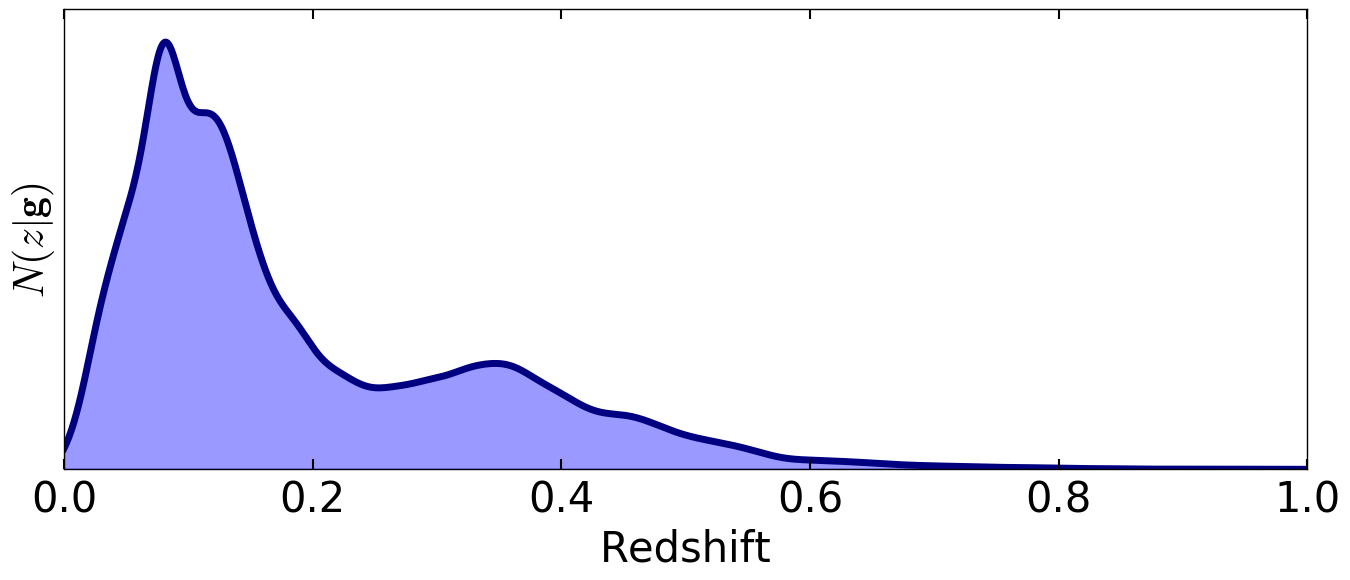

In [18]:
# plotting redshift distribution
figure(figsize=(14,6))

# training
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, ones(Nobs),
                        rdict.grid, rdict.delta, Nobs, rdict.Ngrid)
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres)
z_pdf /= z_pdf.sum()
plot(rdict.zgrid_highres, z_pdf, lw=5, color='navy')
fill_between(rdict.zgrid_highres, z_pdf, color='blue', alpha=0.4)

xlim([0, 1])
yticks([])
tight_layout()
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')

## Posteriors

In [19]:
# initialize FRANKEN-Z instance
frankenz = fz.FRANKENZ(N_members=25, n_neighbors=10)

In [20]:
# compute log-likelihoods
model_obj, model_Nobj, model_ll, model_Nbands = frankenz.predict(phot, err, mask, phot, err, mask)

(0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10) (11) (12) (13) (14) (15) (16) (17) (18) (19) (20) (21) (22) (23) (24) 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 done!


The selection criteria for the spectroscopic sample are complicated/unknown, so we'll disregard that correction here.

To make sure we don't overfit the data, we'll set the output likelihoods for identical objects to zero (i.e. $-2\ln P = +\infty$). This is equivalent to **leave-one-out cross-validation**.

In [21]:
# effectively remove information from our original object
for i in xrange(Nobs):
    model_ll[i,model_obj[i]==i] = inf # -2lnP = +inf.

In [22]:
# compute posteriors
model_post = zeros(model_ll.shape)
model_evid = zeros(Nobs)
prior = ones(Nobs) # uniform prior

for i in arange(Nobs):
    Nm = model_Nobj[i] # number of models
    midx = model_obj[i,:Nm] # model indices
    ll = model_ll[i,:Nm] # log-likelihoods
    like = exp(-0.5*(ll-ll.min())) # scaled likelihoods
    model_evid[i] = like.sum() * exp(-0.5*ll.min())
    post = float64(like * prior[midx]) # scaled posteriors
    post /= post.sum() # normalizing
    model_post[i,:Nm] = post

As before, let's see how our coverage looks.

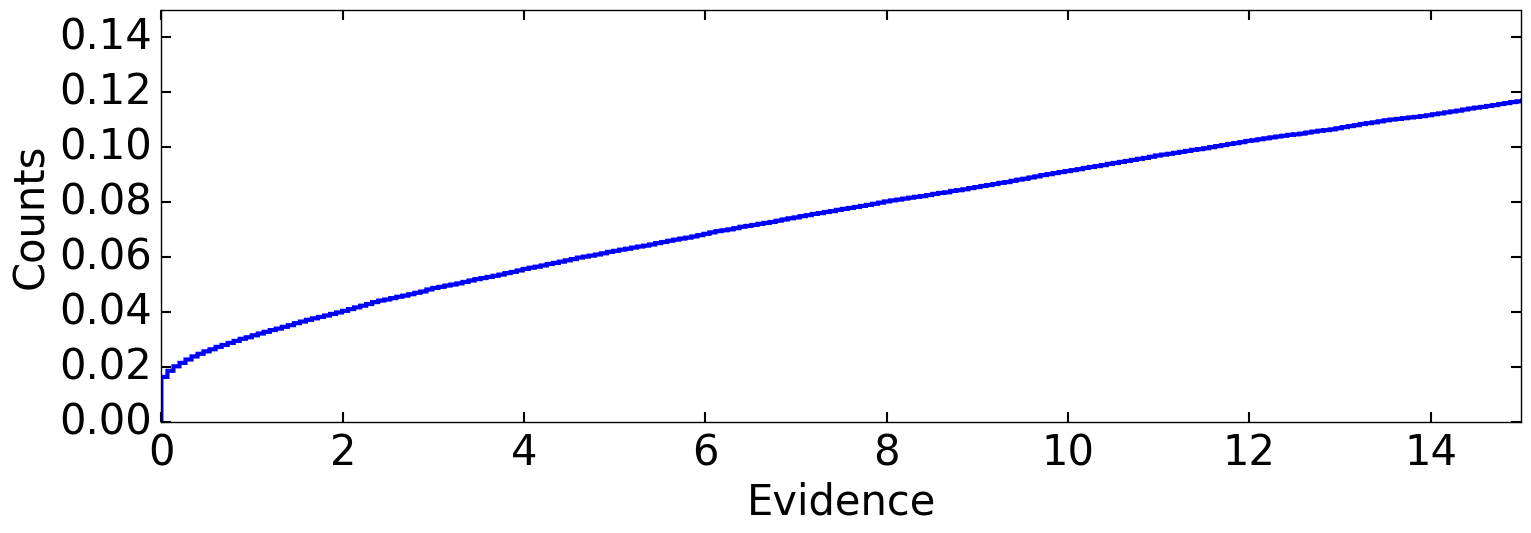

In [23]:
figure(figsize=(16,6))
h = hist(model_evid, 10000, histtype='step', lw=3, normed=True, cumulative=True)
xlabel('Evidence')
xlim([0,15])
ylabel('Counts')
ylim([0,0.15])
tight_layout()

In [24]:
pmask = arange(len(data))[model_evid>10]
Ntrain = Nobs
Ntest = len(pmask)
print('Objects with reasonable coverage {:}/{:}'.format(Ntest, Ntrain))

Objects with reasonable coverage 90685/99781


In [25]:
# computing stacked posteriors
pstack = zeros(Ntrain)
for i in pmask:
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    pstack[midx] += model_post[i,:Nm] # stacked posterior

In [26]:
# compute redshift PDF (truth)
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[pmask], lzeidx[pmask], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf = interp(rdict.zgrid_out, rdict.zgrid_highres, z_pdf)
z_pdf /= z_pdf.sum() # normalizing

# compute redshift PDF (stacked)
z_trn = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, pstack,
                        rdict.grid, rdict.delta, Ntrain, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_trn = z_trn[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_trn = interp(rdict.zgrid_out, rdict.zgrid_highres, z_trn)
z_trn /= z_trn.sum() # normalizing

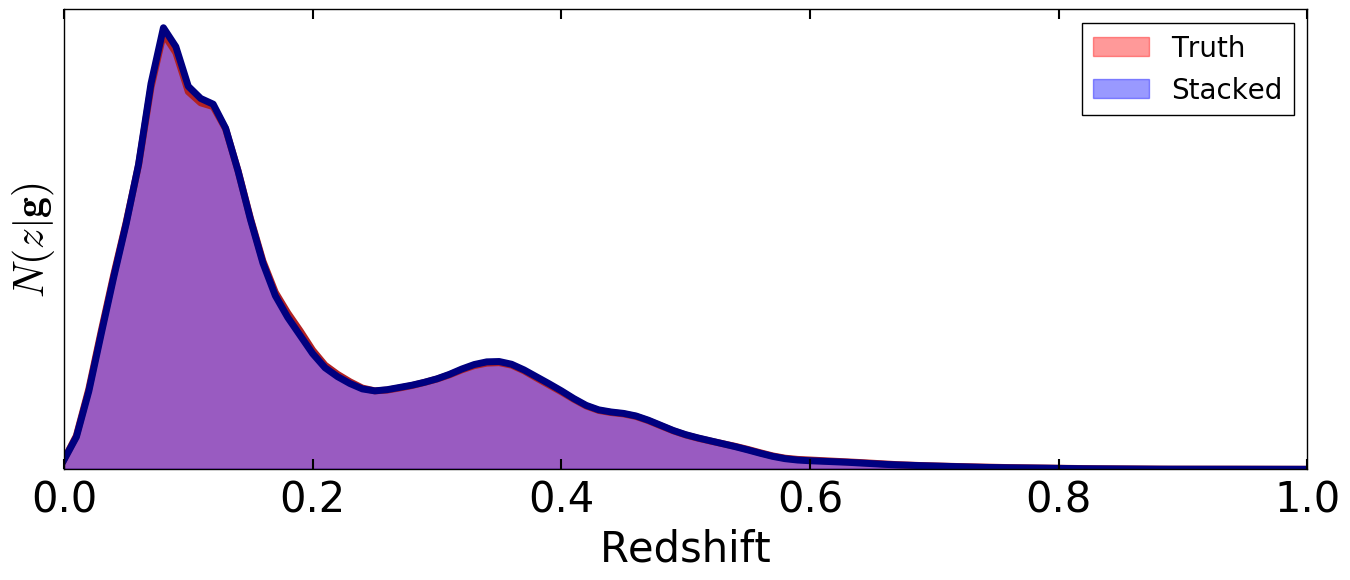

In [27]:
# plotting redshift distribution
figure(figsize=(14,6))

# testing
plot(rdict.zgrid_out, z_pdf, lw=5, color='firebrick')
fill_between(rdict.zgrid_out, z_pdf, color='red', alpha=0.4, label='Truth')

# training
plot(rdict.zgrid_out, z_trn, lw=5, color='navy')
fill_between(rdict.zgrid_out, z_trn, color='blue', alpha=0.4, label='Stacked')

xlim([0, 1])
yticks([])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')

Our initial results look almost identical, which is very promising.

## Population Inference: Posterior

In [28]:
Nsamples = 20 # number of samples

In [29]:
post_samples = zeros((Nsamples, Ntrain), dtype='int')
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm]
        post_samples[i,midx] += multinomial(1, post) # sample object

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

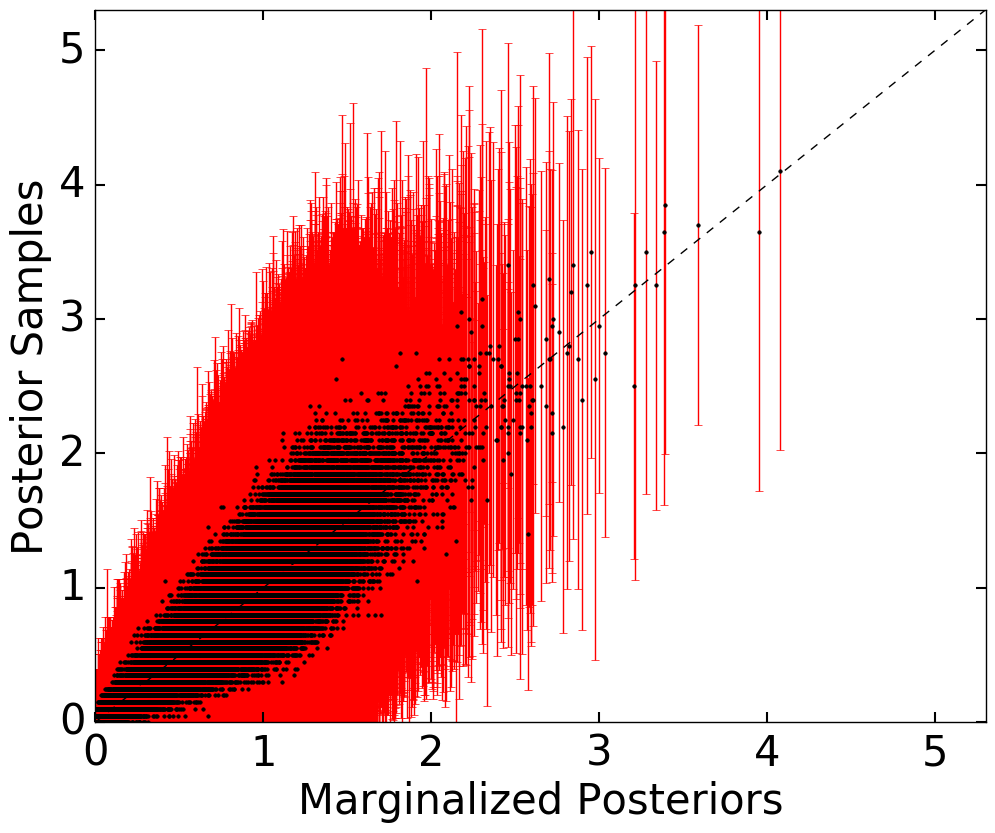

In [30]:
# plotting
figure(figsize=(20,9))
subplot(1,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), ecolor='red', markersize=5, lw=1)
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Posterior Samples')
tight_layout()

In [31]:
# draw redshift samples
post_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, post_samples[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    post_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    post_samples_z[i] *= (Ntest / post_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

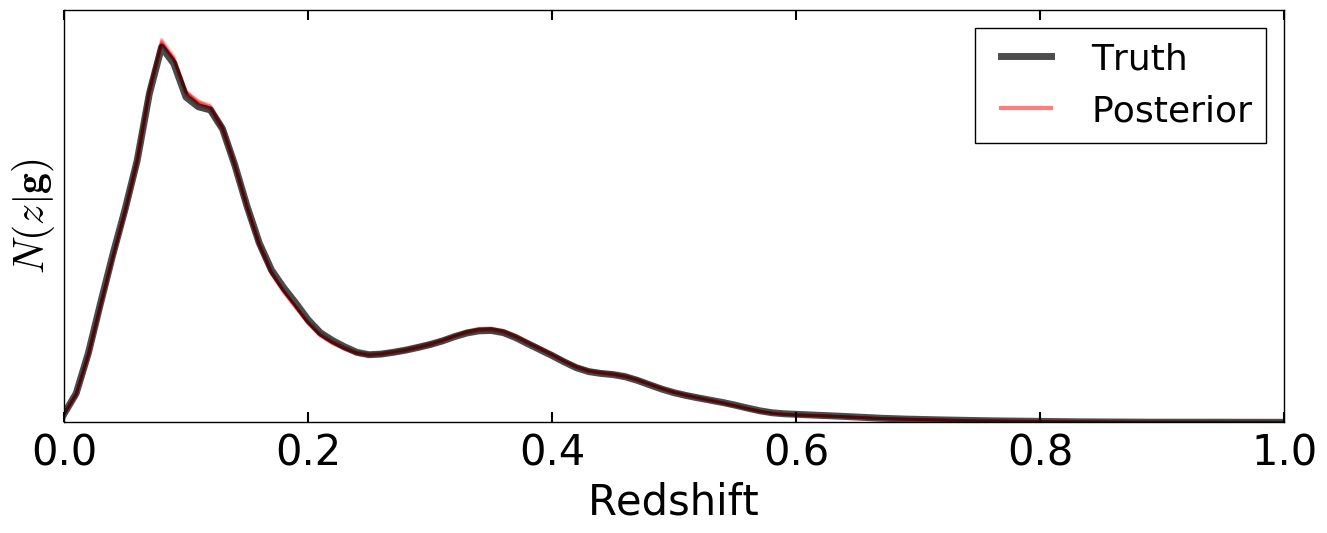

In [32]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, post_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
xlabel('Redshift')
xlim([0, 1])
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.1])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

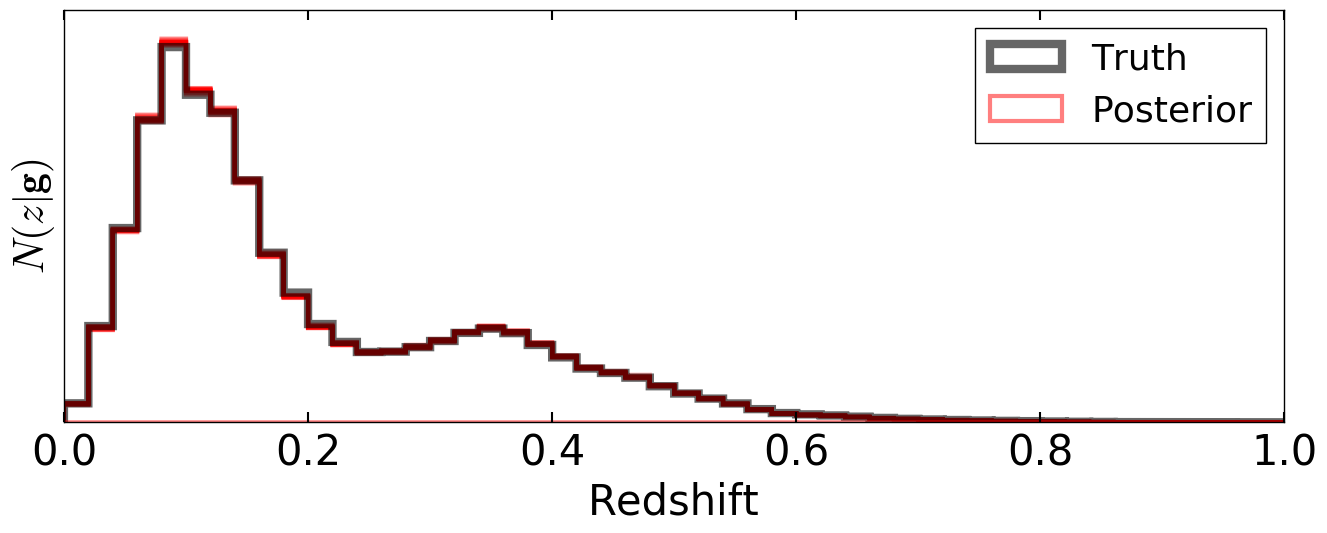

In [33]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::2], weights=post_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::2], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
xlabel('Redshift')
xlim([0, 1])
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

Those look ridiculously similar, so let's plot the relative error to at least get a sense of how far we're off.

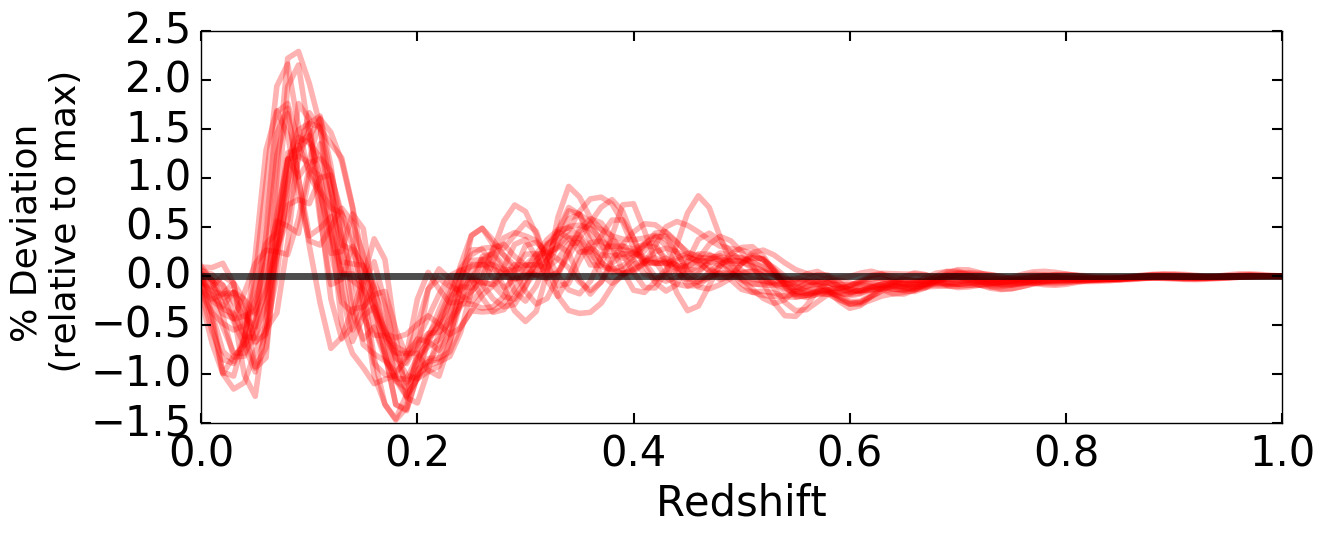

In [53]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, 100* (post_samples_z[i] - z_pdf*Ntest) / (z_pdf.max()*Ntest), lw=4, color='red', alpha=0.3) 
 for i in arange(Nsamples)]
plot(zgrid, z_pdf * 0., lw=5, color='black', alpha=0.7)
xlabel('Redshift')
xlim([0, 1])
ylabel('% Deviation \n (relative to max)', fontsize=26)
tight_layout()

## Hierarchical Inference

In [39]:
# generate samples
Nmcmc = 200 # total number of MCMC draws
hier_samples_n = zeros((Nmcmc, Ntrain))
hier_samples_w = zeros((Nmcmc, Ntrain))

wt = ones(Ntrain) # initialize weights
for i in xrange(Nmcmc):
    sys.stdout.write(str(i)+' ')
    n = zeros(Ntrain) # number counts
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm] * wt[midx]
        post /= post.sum()
        n[midx] += multinomial(1, post) # stack multinomial draw
    wt = dirichlet(n + 1) * Ntest # sample population weight
    hier_samples_n[i], hier_samples_w[i] = n.copy(), wt.copy()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

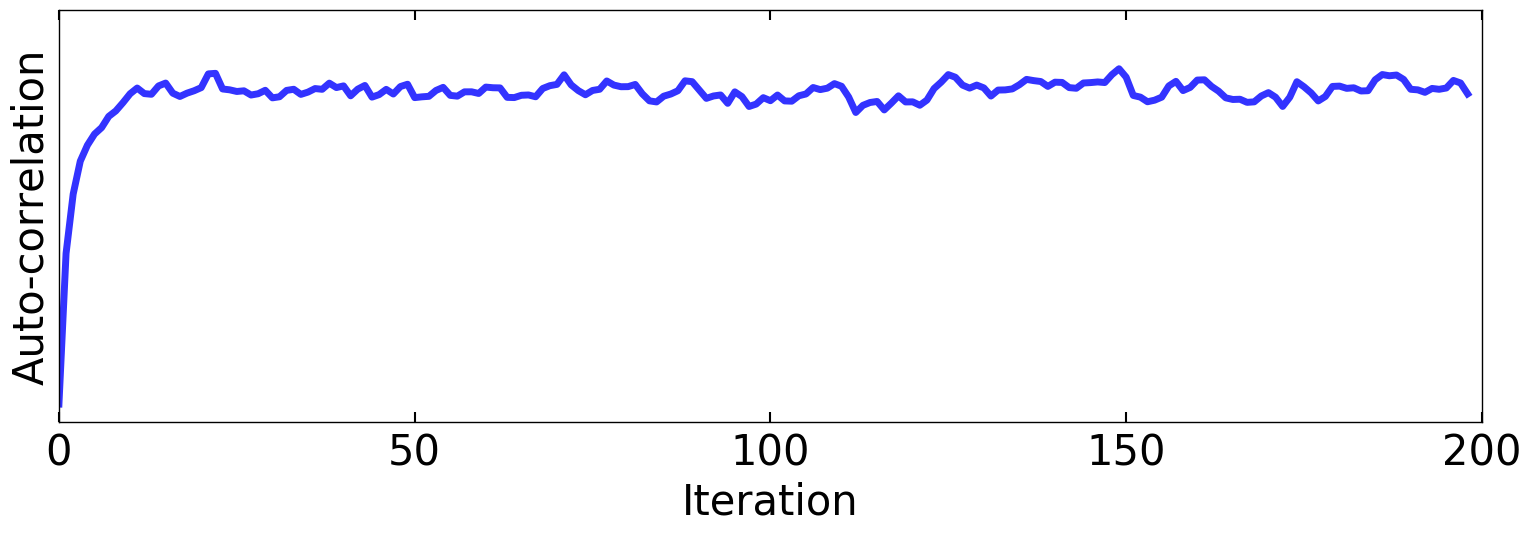

In [40]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(hier_samples_n[i], hier_samples_n[i+1]) for i in arange(Nmcmc-1)]).flatten()
plot(arange(Nmcmc-1), autocorr, lw=5, color='blue', alpha=0.8, label='Original')
xlabel('Iteration')
ylabel('Auto-correlation')
yticks([])
xlim([0, Nmcmc])
tight_layout()

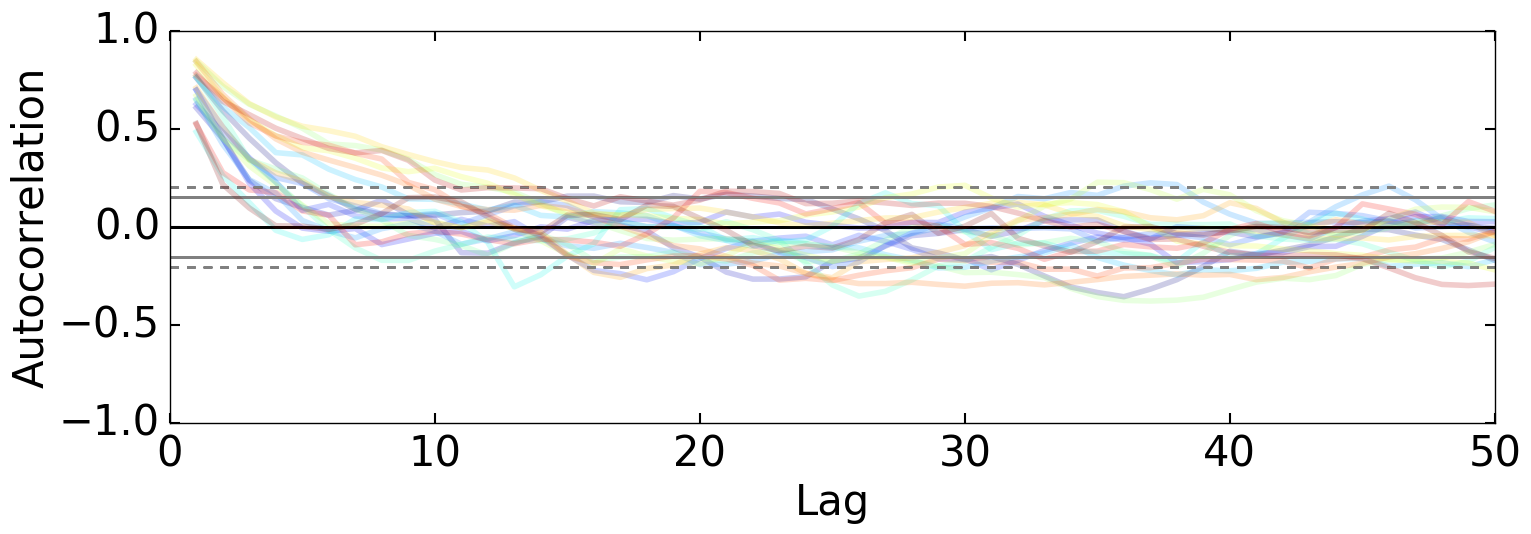

In [41]:
Nburnin = 40 # burn-in
indices = argsort(hier_samples_w[Nburnin:].mean(axis=0))[::-1] # sort from largest to smallest weights

# plot autocorrelation lag
figure(figsize=(16,6))
colors = get_cmap('jet')(linspace(0,1,20))
h = [autocorrelation_plot(hier_samples_w[Nburnin:,indices[i]], color=colors[i], lw=4, alpha=0.2) for i in xrange(20)]
xlim([0, 50])
tight_layout()

Let's look at the traces of a few samples.

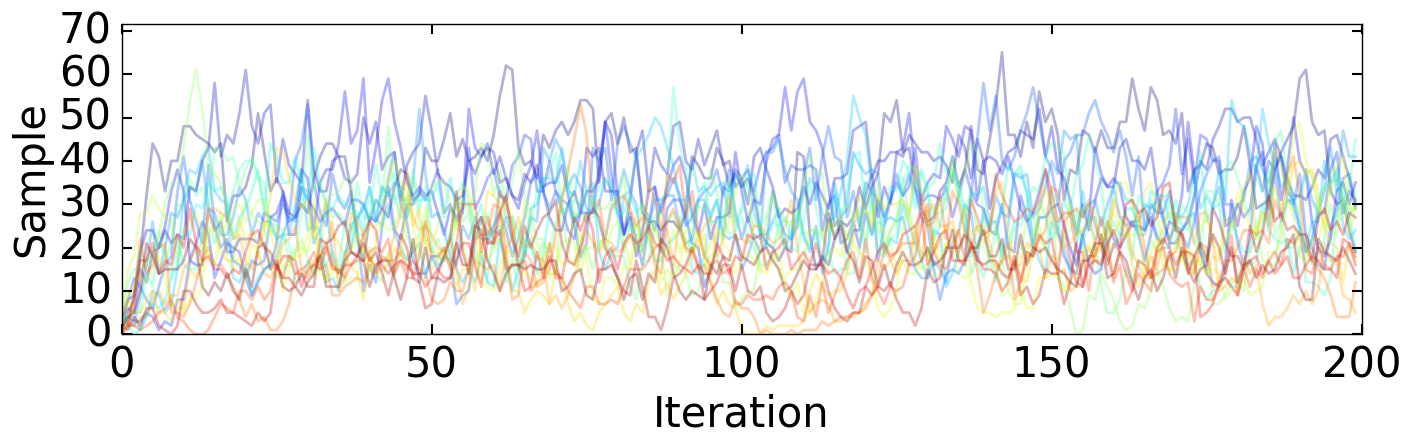

In [42]:
# plot samples
figure(figsize=(16,4))
for i in xrange(20):
    idx = indices[i]
    plot(arange(Nmcmc), hier_samples_n[:,idx], color=colors[i], lw=2, alpha=0.3)
ylim([max(0,hier_samples_n[Nburnin:,indices[:20]].min()-100), hier_samples_n[Nburnin:,indices[:20]].max()*1.1])
xlim([0, Nmcmc])
xlabel('Iteration')
ylabel('Sample')

In [43]:
# thinning
Nthin = 8
hier_samples_t = hier_samples_n[Nburnin::Nthin]

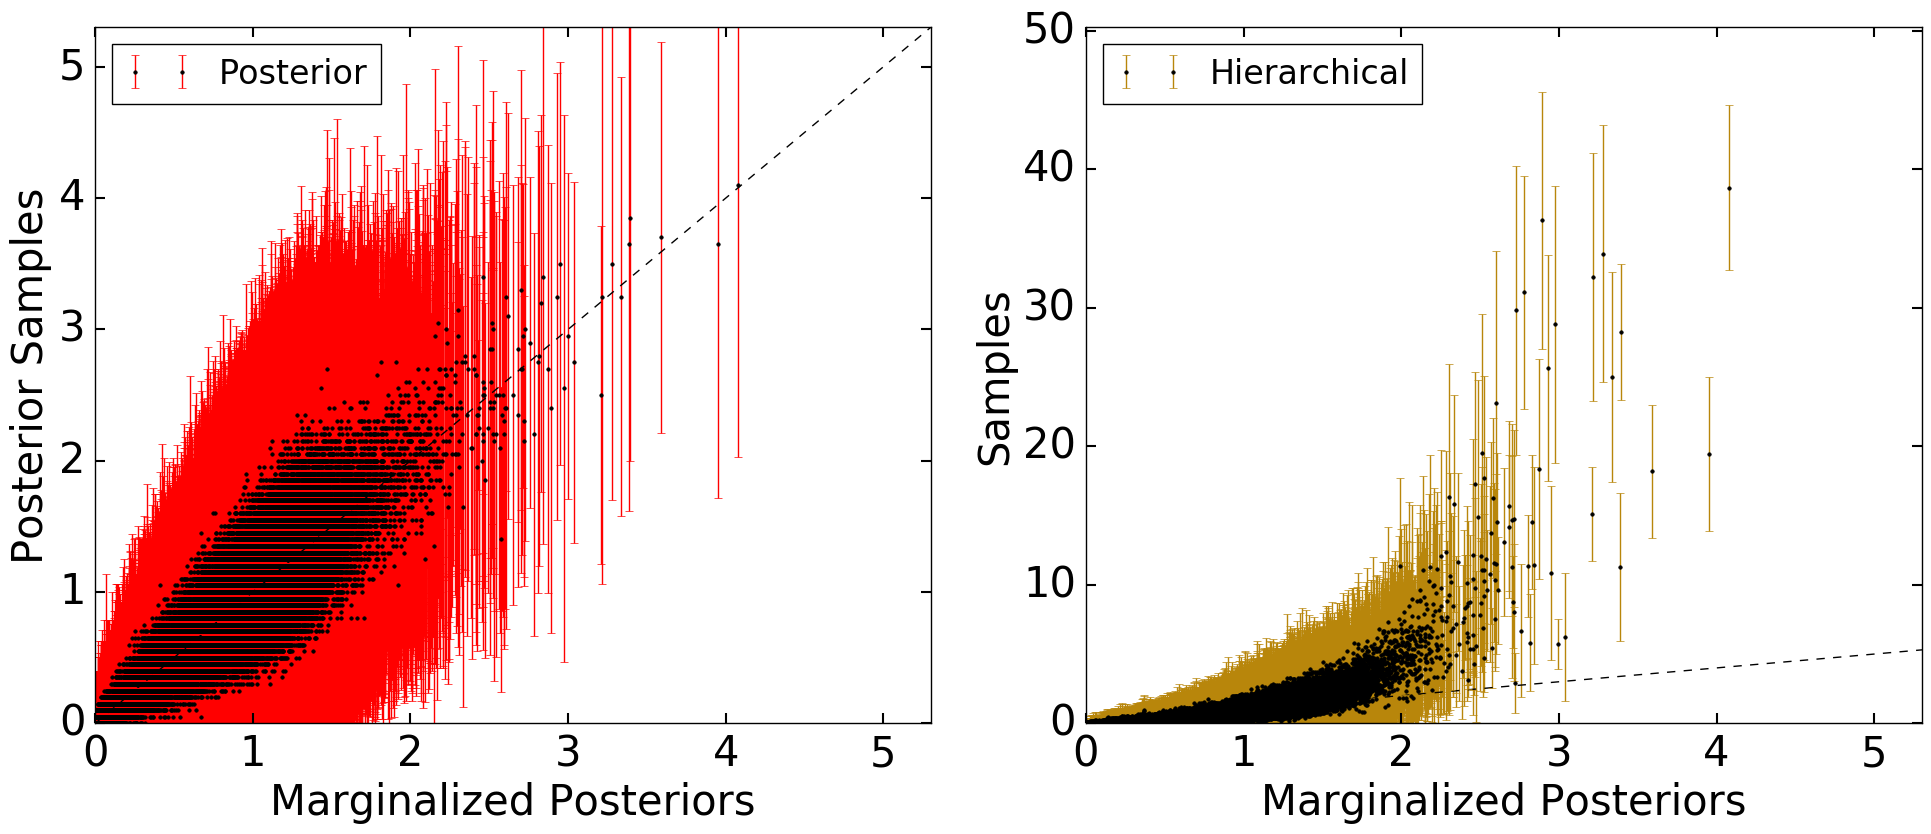

In [44]:
# plotting
figure(figsize=(20,9))
subplot(1,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), 
         ecolor='red', markersize=5, lw=1, label='Posterior')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Posterior Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(1,2,2)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, hier_samples_t.mean(axis=0), fmt='k.', yerr=hier_samples_t.std(axis=0), 
         ecolor='darkgoldenrod', markersize=5, lw=1,
         label='Hierarchical')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, hier_samples_t.mean(axis=0).max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()

In [45]:
# draw redshift samples
hier_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, hier_samples_t[i], 
                           rdict.lzgrid_highres, rdict.dlz, Ntrain, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    hier_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    hier_samples_z[i] *= (Ntest / hier_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

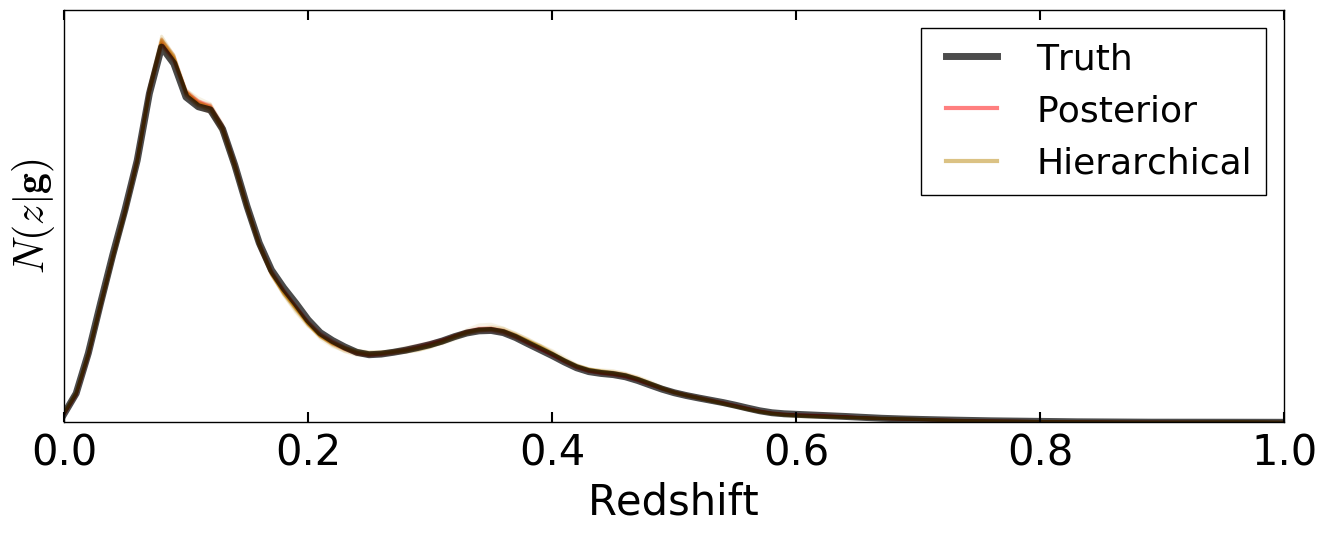

In [46]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, post_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, hier_samples_z[i], lw=2, color='darkgoldenrod', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
xlim([0, 1])
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.1])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

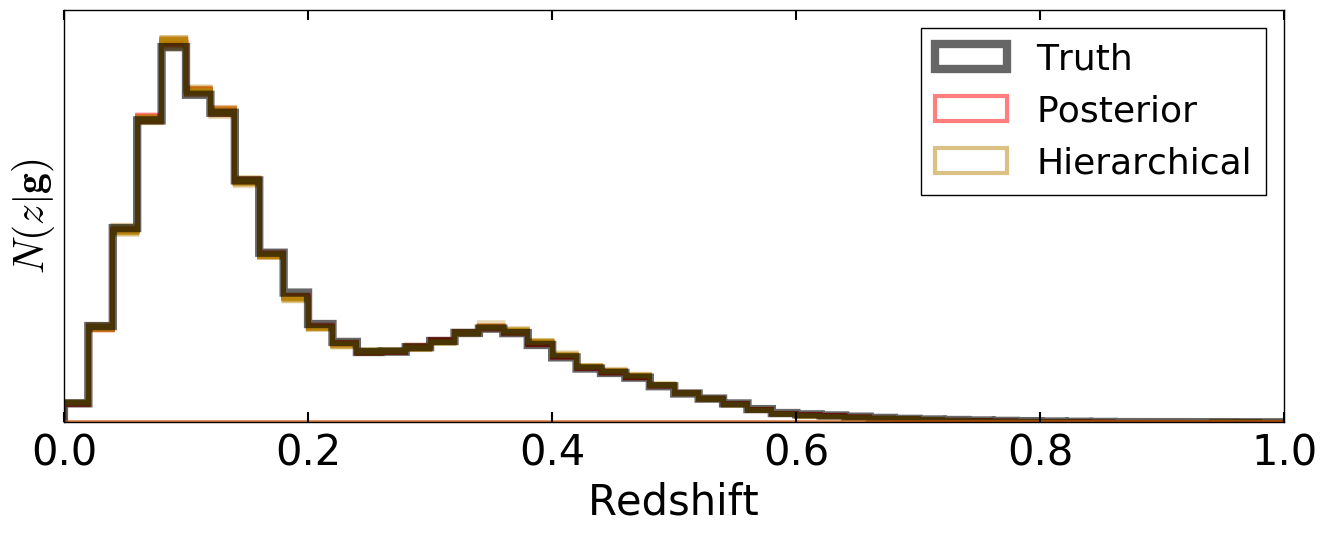

In [47]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::2], weights=post_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::2], weights=hier_samples_z[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::2], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
xlim([0, 1])
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$N(z|\mathbf{g})$')
legend(fontsize=26, loc='best')
tight_layout()

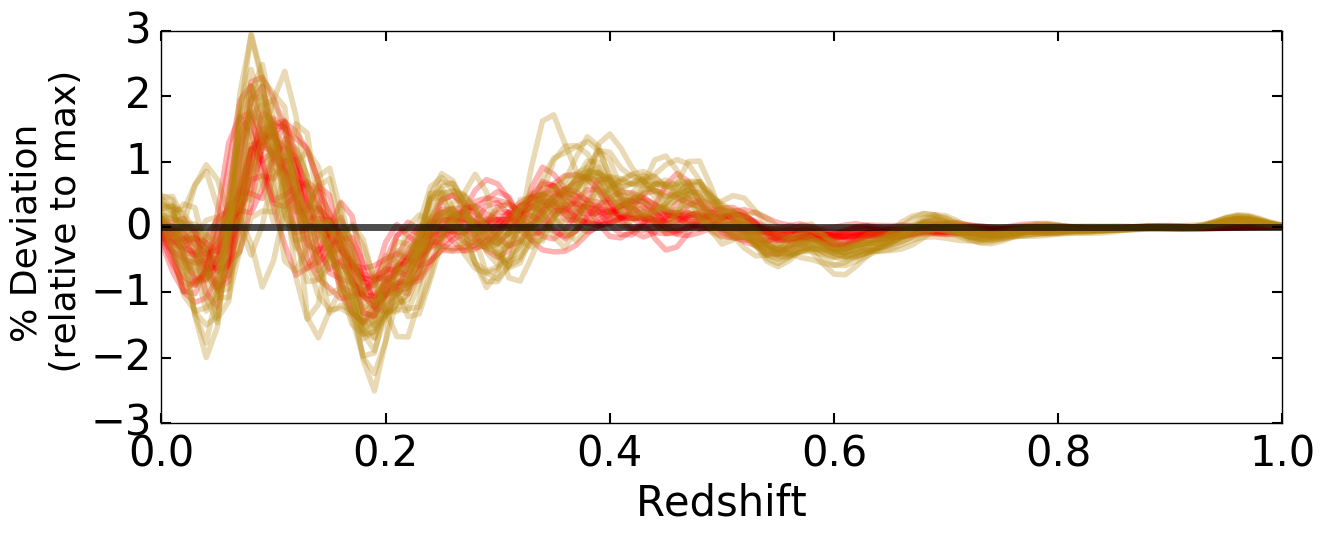

In [51]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, 100* (post_samples_z[i] - z_pdf*Ntest) / (z_pdf.max()*Ntest), lw=4, color='red', alpha=0.3) 
 for i in arange(Nsamples)]
[plot(zgrid, 100* (hier_samples_z[i] - z_pdf*Ntest) / (z_pdf.max()*Ntest), lw=4, color='darkgoldenrod', alpha=0.3) 
 for i in arange(Nsamples)]
plot(zgrid, z_pdf * 0., lw=5, color='black', alpha=0.7)
xlabel('Redshift')
xlim([0, 1])
ylabel('% Deviation \n (relative to max)', fontsize=26)
tight_layout()

We can see our hierarchical model has a broader error distribution that better agrees with the true underlying distribution.

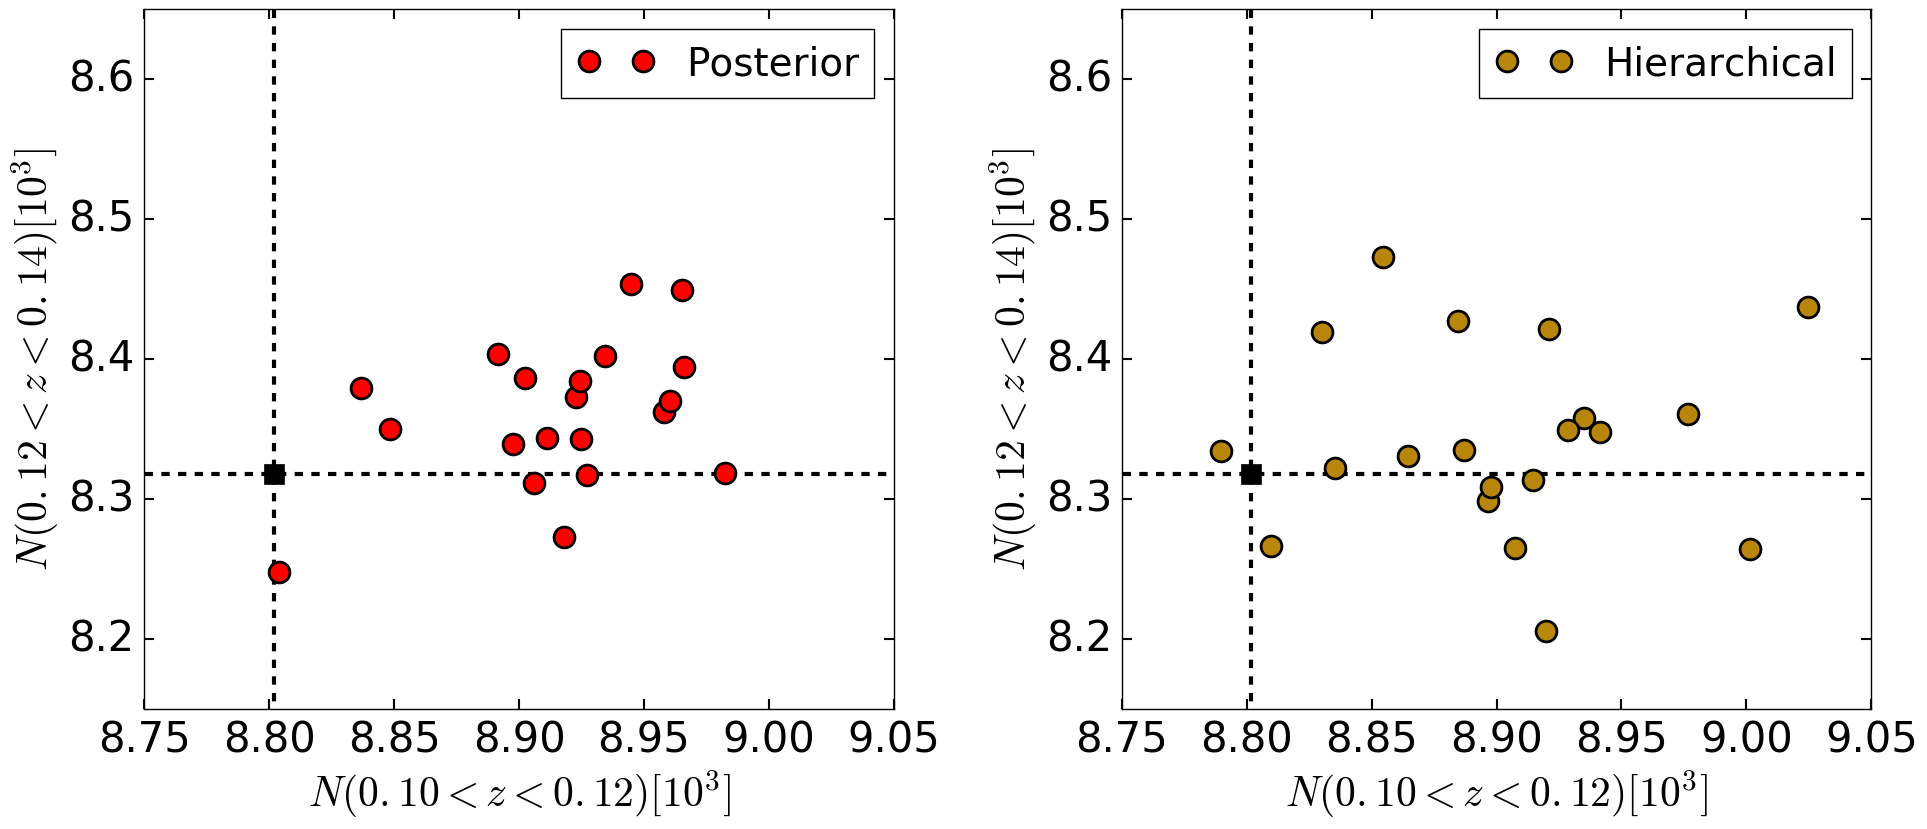

In [58]:
figure(figsize=(20,9))
subplot(1,2,1)
vlines(z_pdf[10:12].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[12:14].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[10:12].sum()*Ntest/1e3, z_pdf[12:14].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(post_samples_z[:,10:12].sum(axis=1)/1e3, post_samples_z[:,12:14].sum(axis=1)/1e3, 'o', color='red', 
     label='Posterior', markersize=15, markeredgewidth=2)
ylim([8.15, 8.65])
xlim([8.75, 9.05])
xlabel('$N(0.10<z<0.12) [10^3]$')
ylabel('$N(0.12<z<0.14) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(1,2,2)
vlines(z_pdf[10:12].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
hlines(z_pdf[12:14].sum()*Ntest/1e3, 0, 10, colors='black', lw=3, linestyles='--')
plot(z_pdf[10:12].sum()*Ntest/1e3, z_pdf[12:14].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(hier_samples_z[:,10:12].sum(axis=1)/1e3, hier_samples_z[:,12:14].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=15, markeredgewidth=2)
ylim([8.15, 8.65])
xlim([8.75, 9.05])
xlabel('$N(0.10<z<0.12) [10^3]$')
ylabel('$N(0.12<z<0.14) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()

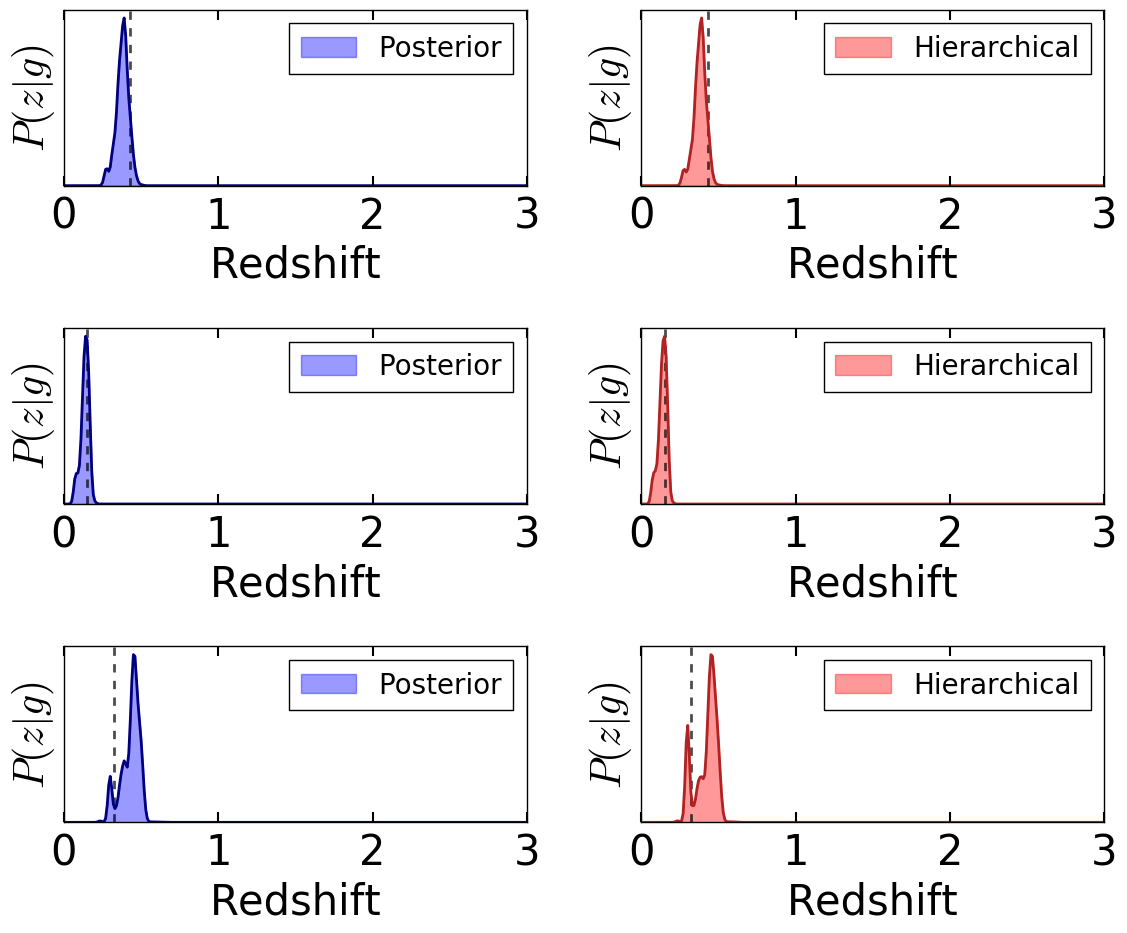

In [64]:
# comparison for a few PDFs
prior = hier_samples_w[Nburnin:].mean(axis=0)

# plotting
indices = choice(pmask, size=3, replace=False)

# testing
figure(figsize=(12,10))
for i in xrange(3):
    idx = indices[i]
    Nm = model_Nobj[idx]
    midx, post = model_obj[idx,:Nm], model_post[idx,:Nm]
    hier_post = post * hier_samples_w[Nburnin::Nthin,midx]
    hier_post /= hier_post.sum(axis=1)[:,None]
    hier_post = hier_post.sum(axis=0)/Nsamples
    subplot(3,2,2*i+1)
    pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[midx], lzeidx[midx], post,
                          rdict.grid, rdict.delta, Nm, rdict.Ngrid) # smooth PDF generated using input dictionaries
    pdf = pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    pdf = interp(zgrid, rdict.zgrid_highres, pdf) # resampling
    pdf /= pdf.sum() # normalizing
    plot(zgrid, pdf, lw=2, color='navy')
    fill_between(zgrid, pdf, color='blue', alpha=0.4, label='Posterior')
    vlines(data['SPEC_Z'][idx], 0, 1e2, colors='black', linestyles='--', lw=2, alpha=0.7)
    xlabel('Redshift')
    xlim([0,3])
    xticks(arange(4))
    ylabel('$P(z|g)$')
    ylim([None, pdf.max()*1.05])
    yticks([])
    legend(fontsize=20)
    tight_layout()
    subplot(3,2,2*i+2)
    pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[midx], lzeidx[midx], hier_post,
                          rdict.grid, rdict.delta, Nm, rdict.Ngrid) # smooth PDF generated using input dictionaries
    pdf = pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    pdf = interp(zgrid, rdict.zgrid_highres, pdf) # resampling
    pdf /= pdf.sum() # normalizing
    plot(zgrid, pdf, lw=2, color='firebrick')
    fill_between(zgrid, pdf, color='red', alpha=0.4, label='Hierarchical')
    vlines(data['SPEC_Z'][idx], 0, 1e2, colors='black', linestyles='--', lw=2, alpha=0.7)
    xlabel('Redshift')
    xlim([0,3])
    xticks(arange(4))
    ylabel('$P(z|g)$')
    ylim([None, pdf.max()*1.05])
    yticks([])
    legend(fontsize=20)
    tight_layout()